In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

#### Code 2.1

In [3]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

#### Model building

1. Data Story
1. Update
1. Evaluation

    3.1. Model may be certain, but it's still only in model's world
    
    3.2. Supervise and critique model's work (i.e. indirect influence on the model)

#### Code 2.2

$$Pr(w \mid n, p) =  \frac{n!}{w!(n − w)!} p^w (1 − p)^{n−w}$$


The probability of observing six W’s in nine tosses — below a value of $p=0.5$.

In [4]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000006

$$Posterior = \frac{Probablity \; of \; the \; data \; \times \; Prior}{Average \; probability \; of \; the \; data}$$

#### Code 2.3 and 2.5

Computing the posterior using a grid approximation.

In the book, the following code is not inside a function, but this way it is easier to play with different parameters.

In [25]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(1 / grid_points, grid_points)  # uniform
#     prior = (p_grid >= 0.5).astype(int)  # truncated
    prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

#### Code 2.3

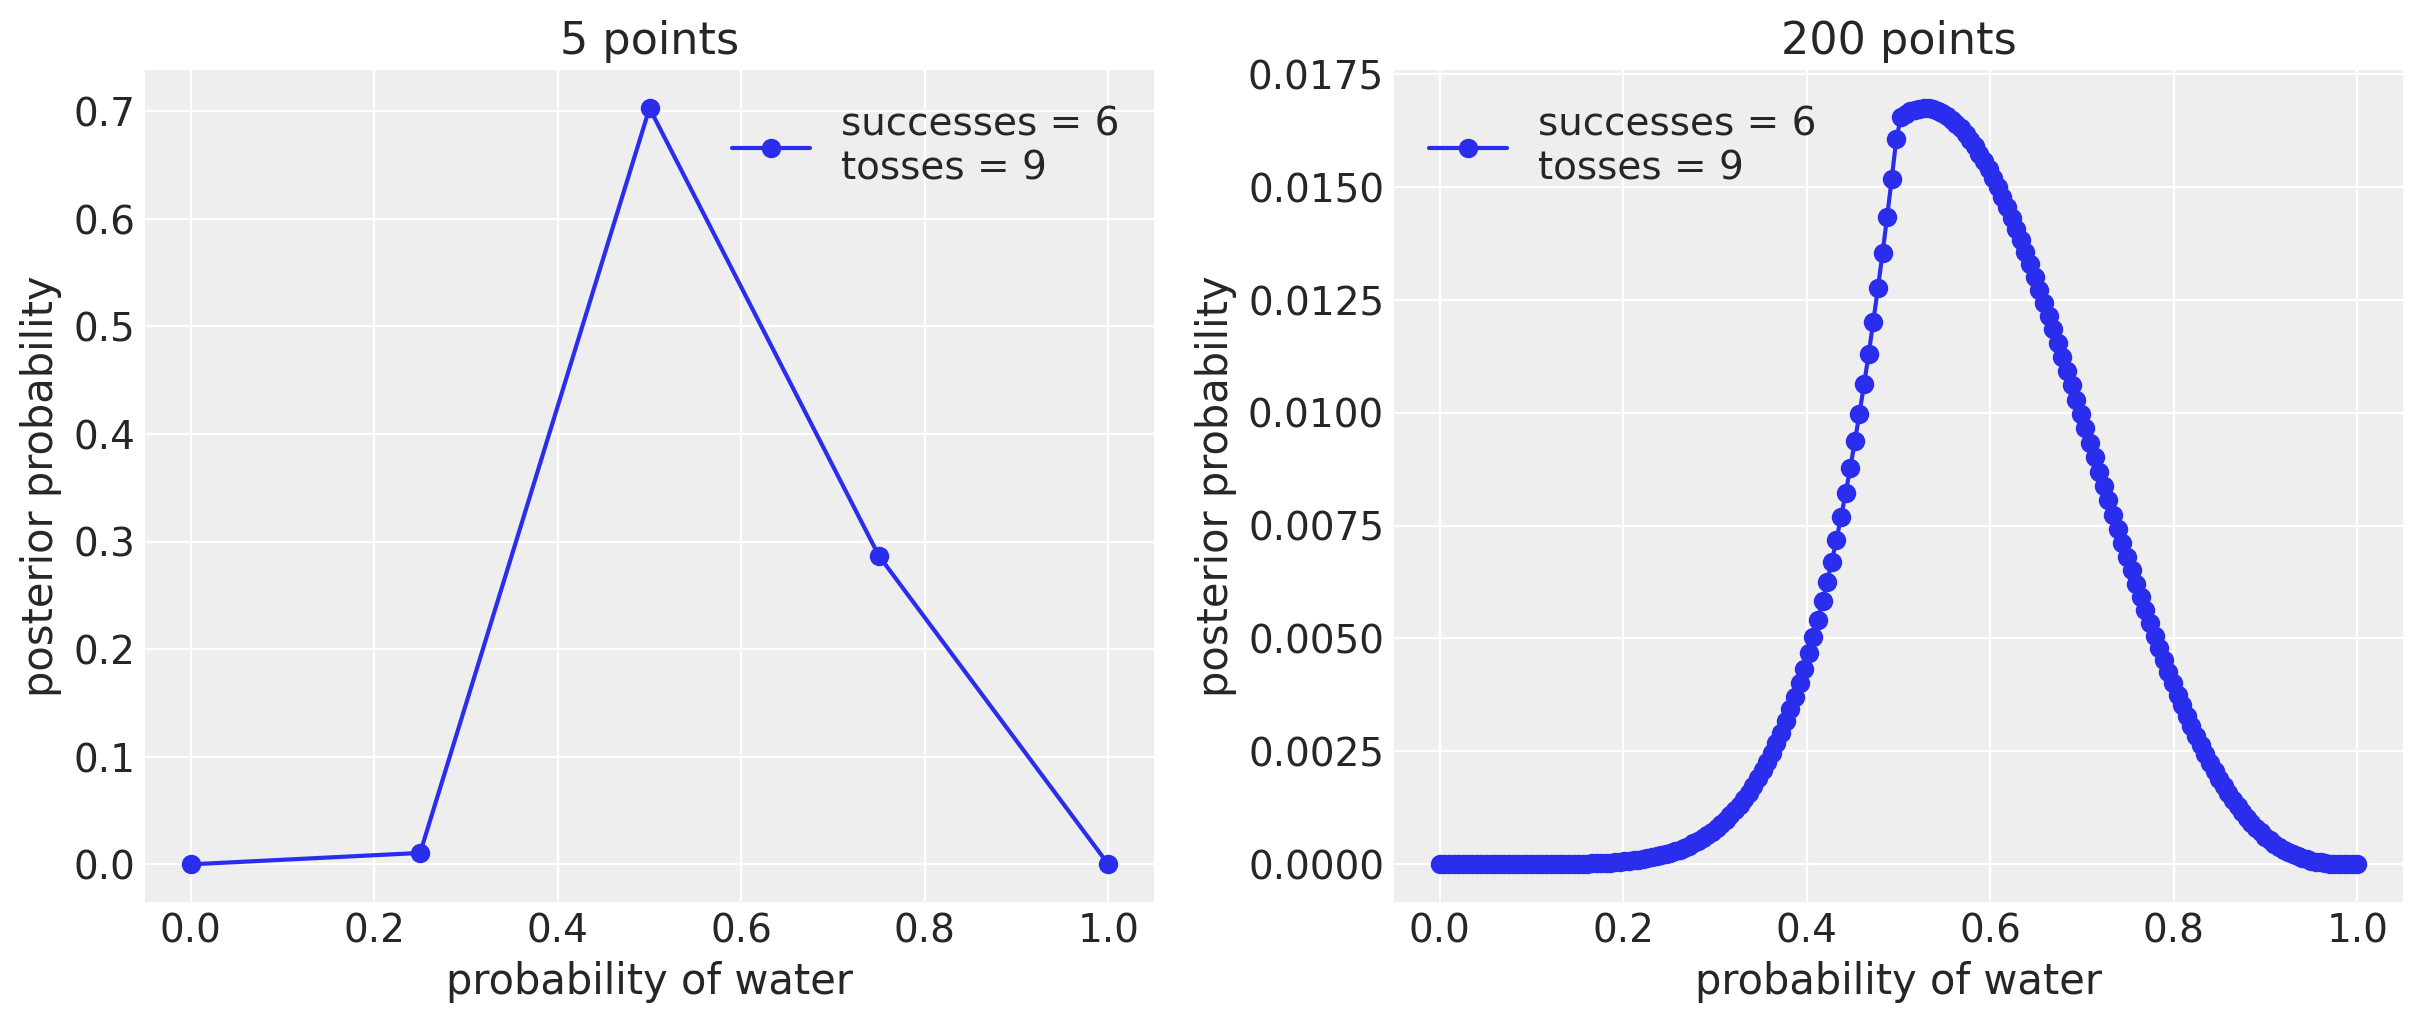

In [26]:
w, n = 6, 9

_, ax = plt.subplots(1, 2, figsize=(12, 5))

points = (5, 200)
for idx, ps in enumerate(points):
    p_grid, posterior = posterior_grid_approx(ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
#     ax[idx].plot(p_grid, prior, "x-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

### Quadratic approximation
The assumption is that near the maximum of the likelhood function it can be approximated with Gaussian distr.

If there is a problem with finding hessian it means that the model has some problemm with calculating standard deviation of a model.

#### Code 2.6

Computing the posterior using the quadratic aproximation (quad).

In [7]:
np.repeat((0, 1), (3, 6))

array([0, 0, 0, 1, 1, 1, 1, 1, 1])

In [8]:
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_aproximation:
    p = pm.Uniform("p", 0, 1)  # uniform priors
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
    mean_q = pm.find_MAP()
    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

# display summary of quadratic approximation
print('  Mean, Standard deviation\np {:.2}, {:.2}'.format(mean_q["p"], std_q[0]))


  Mean, Standard deviation
p 0.67, 0.16


In [9]:
# Compute the 89% percentile interval
norm = stats.norm(mean_q, std_q)
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
pi = mean_q["p"] + std_q * z
print('5.5%, 94.5% \n{:.2}, {:.2}'.format(pi[0], pi[1]))

5.5%, 94.5% 
0.42, 0.92


#### Code 2.7

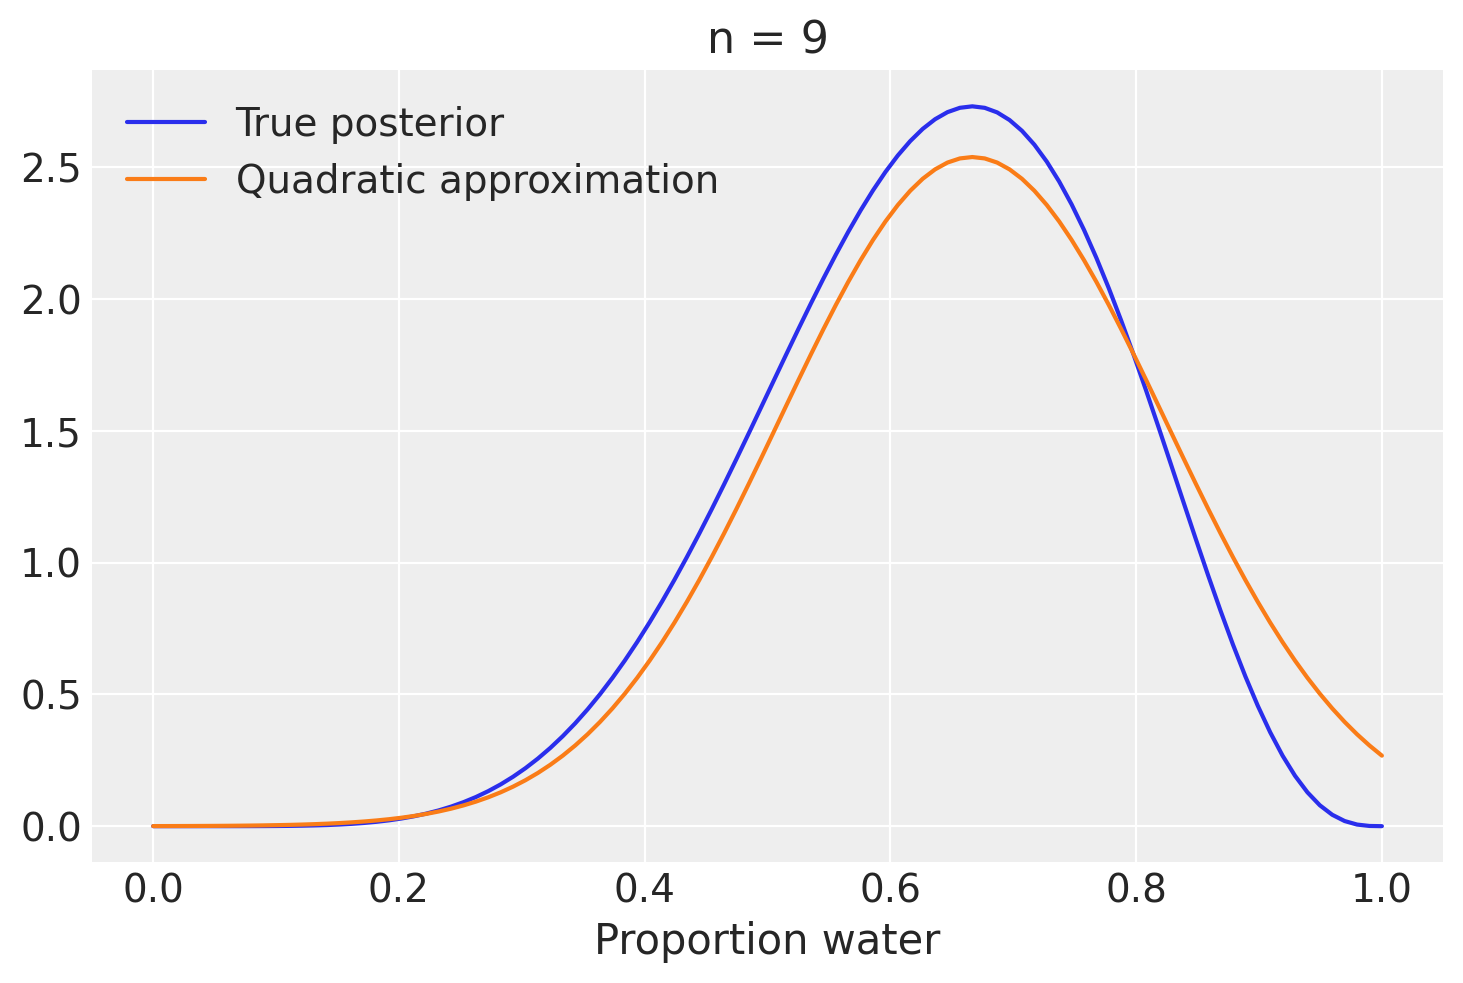

In [10]:
# analytical calculation
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, w + 1, n - w + 1), label="True posterior")

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
plt.legend(loc=0)

plt.title(f"n = {n}")
plt.xlabel("Proportion water");

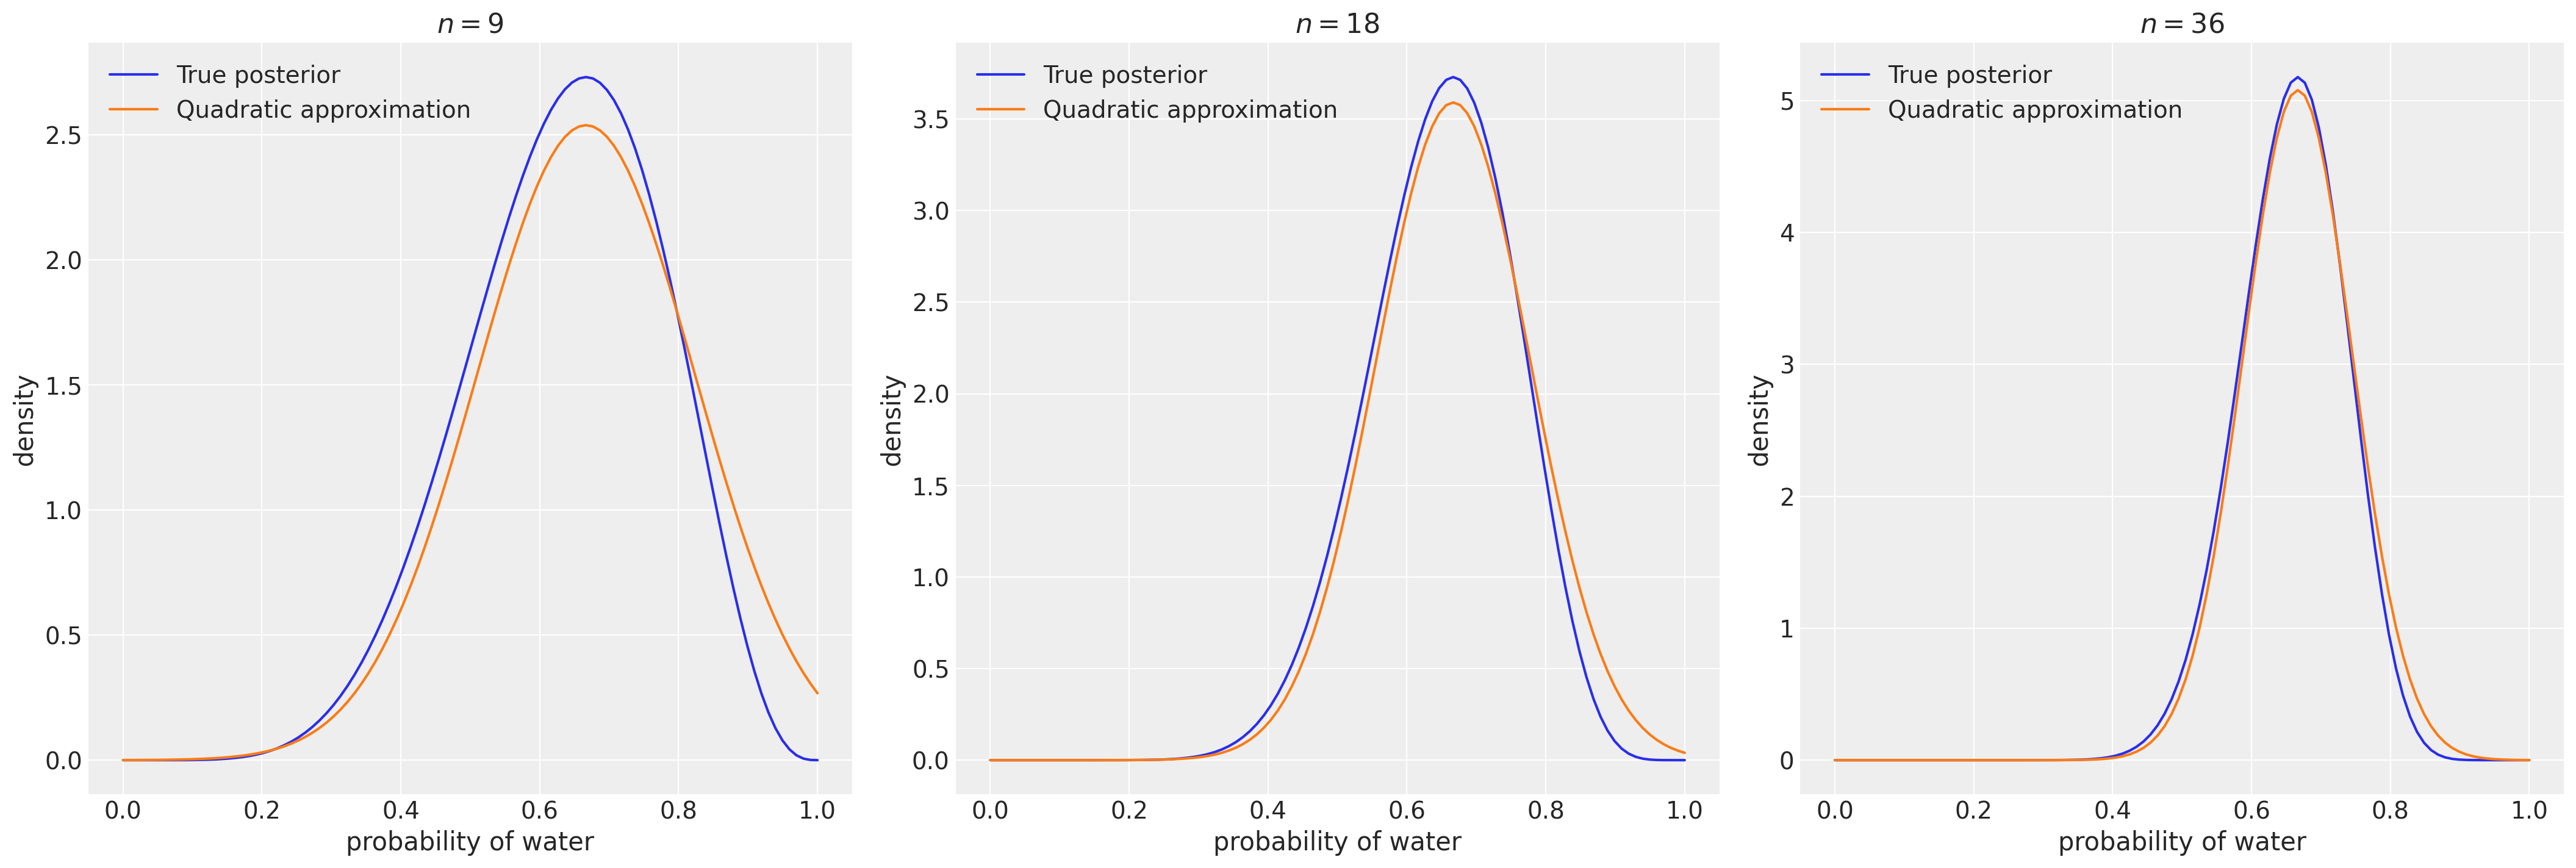

In [11]:
# Figure 2.8
x = np.linspace(0, 1, 100)
w, n = [6, 12, 24], [9, 18, 36]

fig, ax = plt.subplots(1,3, figsize=(21,7))

for idx, ps in enumerate(zip(w,n)):
    data = np.repeat((0, 1), (ps[1]-ps[0], ps[0]))
    with pm.Model() as normal_aproximation:
        p = pm.Uniform("p", 0, 1)  # uniform priors
        w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
        mean_q = pm.find_MAP()
        std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]
    
    
    ax[idx].plot(x, stats.beta.pdf(x, ps[0] + 1, ps[1] - ps[0] + 1), label="True posterior")
    ax[idx].plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("density")
    ax[idx].set_title(r"$n={}$".format(ps[1]))
    ax[idx].legend(loc='upper left')

#### Code 2.8

In [12]:
n_samples = 10000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = stats.norm(p[i - 1], 0.1).rvs(1)
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(W, n=W + L, p=p[i - 1])
    q1 = stats.binom.pmf(W, n=W + L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

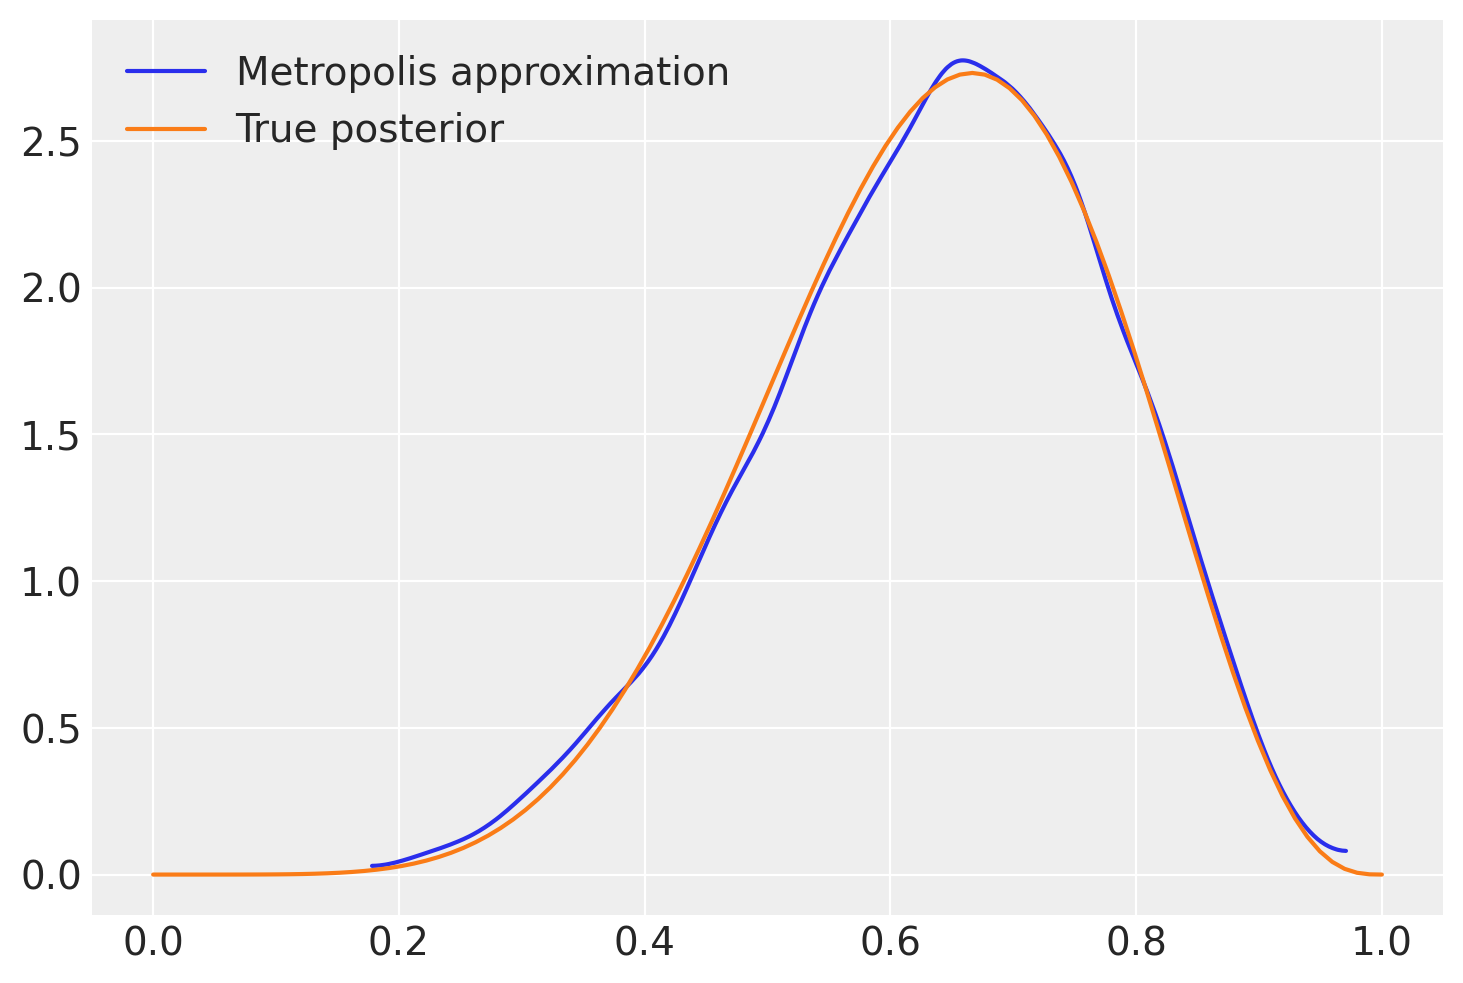

In [13]:
az.plot_kde(p, label="Metropolis approximation")
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W + 1, L + 1), "C1", label="True posterior")
plt.legend();

### Practice

#### 2E1
(2) P(rain|Monday) and (4) P(rain, Monday) / P(Monday)

#### 2E2
(3)

#### 2E3
(1) P(Monday|rain) and (4) P(rain|Monday) * P(Monday) / P(rain)

#### 2M1

In [28]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(1 / grid_points, grid_points)  # uniform
#     prior = (p_grid >= 0.5).astype(int)  # truncated
#     prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

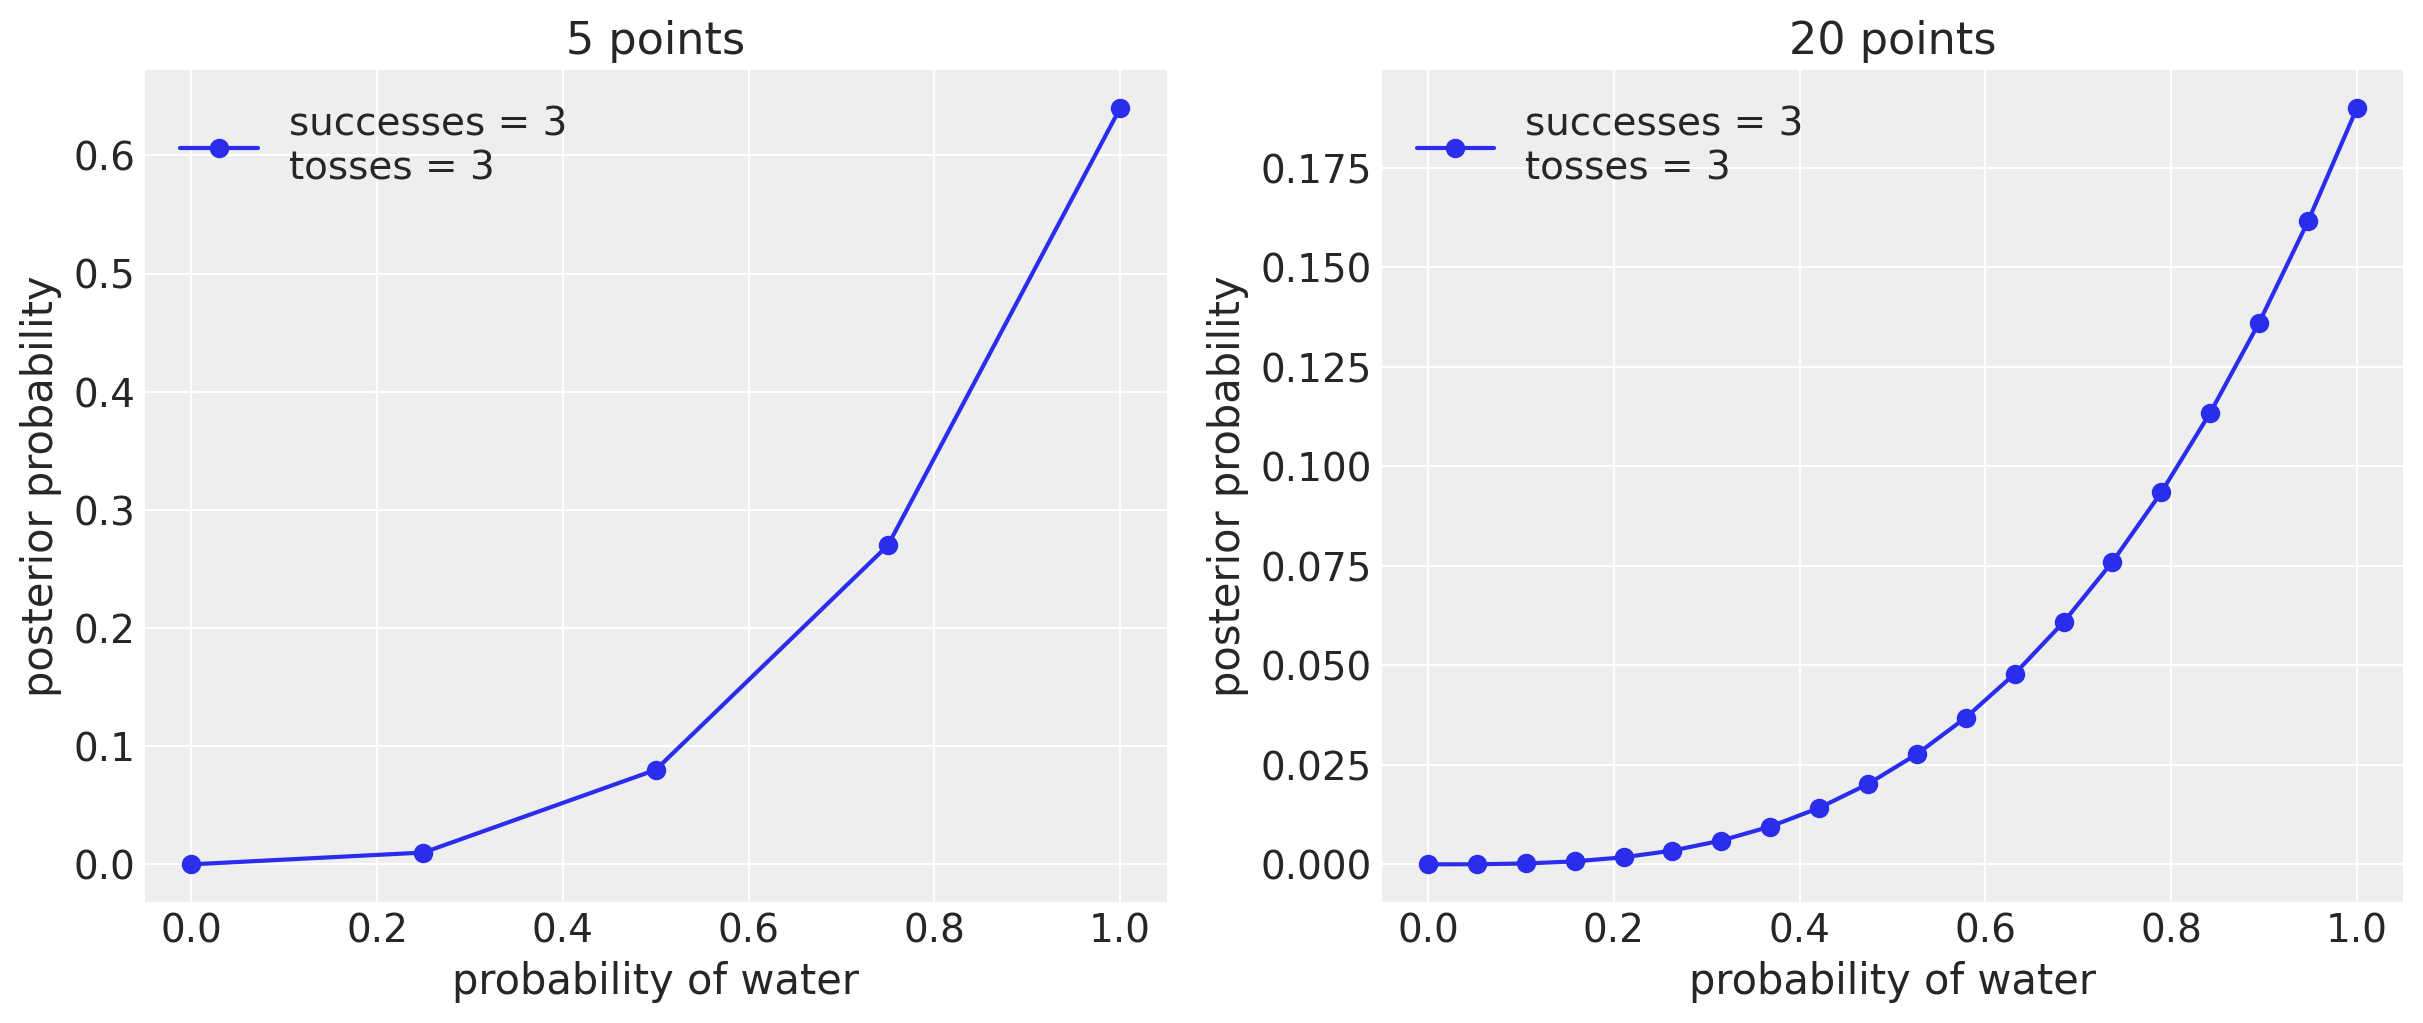

In [29]:
w, n = 3, 3

_, ax = plt.subplots(1, 2, figsize=(12, 5))

points = (5, 20)
for idx, ps in enumerate(points):
    p_grid, posterior = posterior_grid_approx(ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

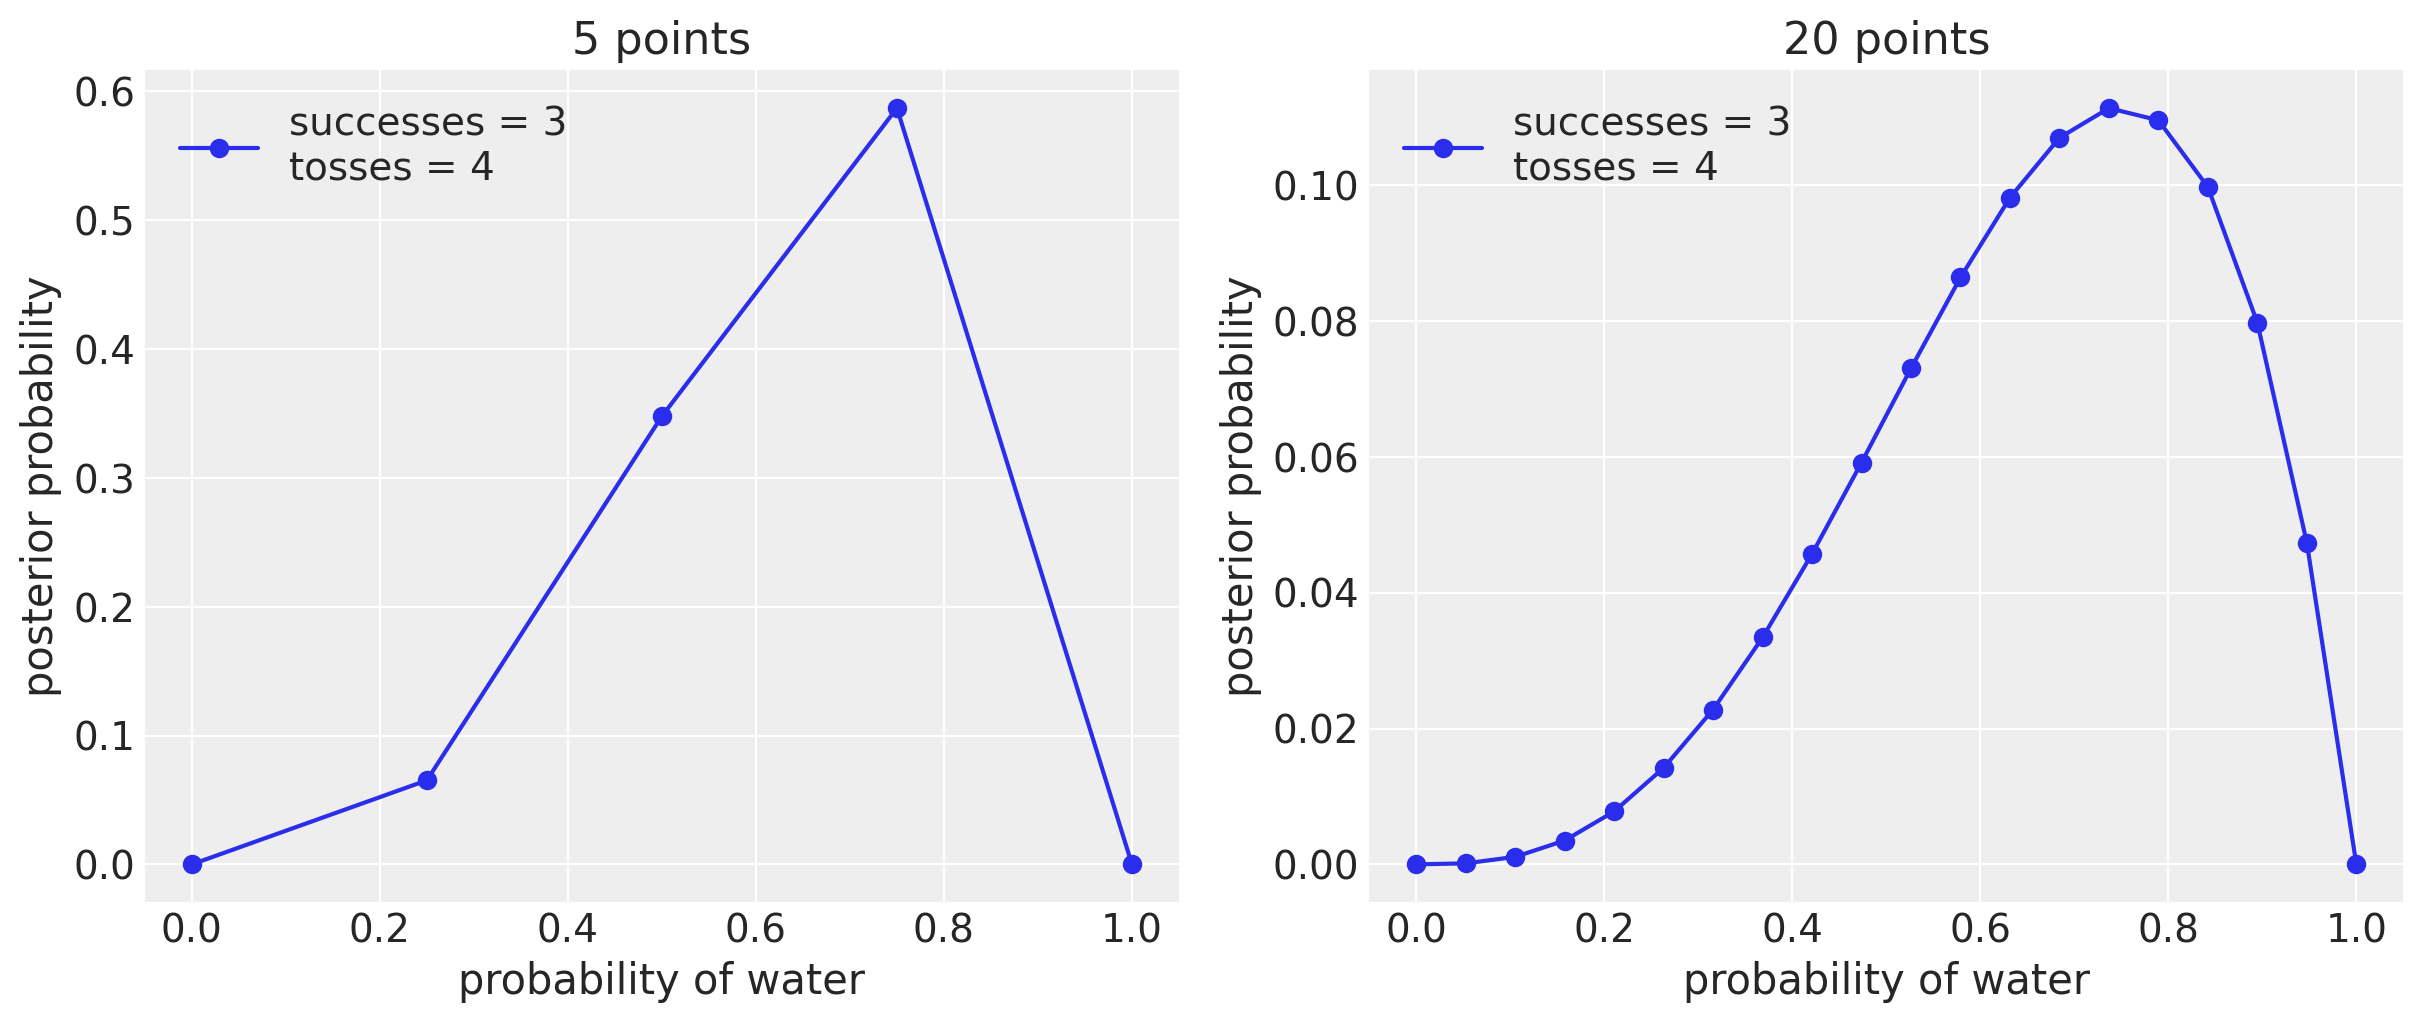

In [30]:
w, n = 3, 4

_, ax = plt.subplots(1, 2, figsize=(12, 5))

points = (5, 20)
for idx, ps in enumerate(points):
    p_grid, posterior = posterior_grid_approx(ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

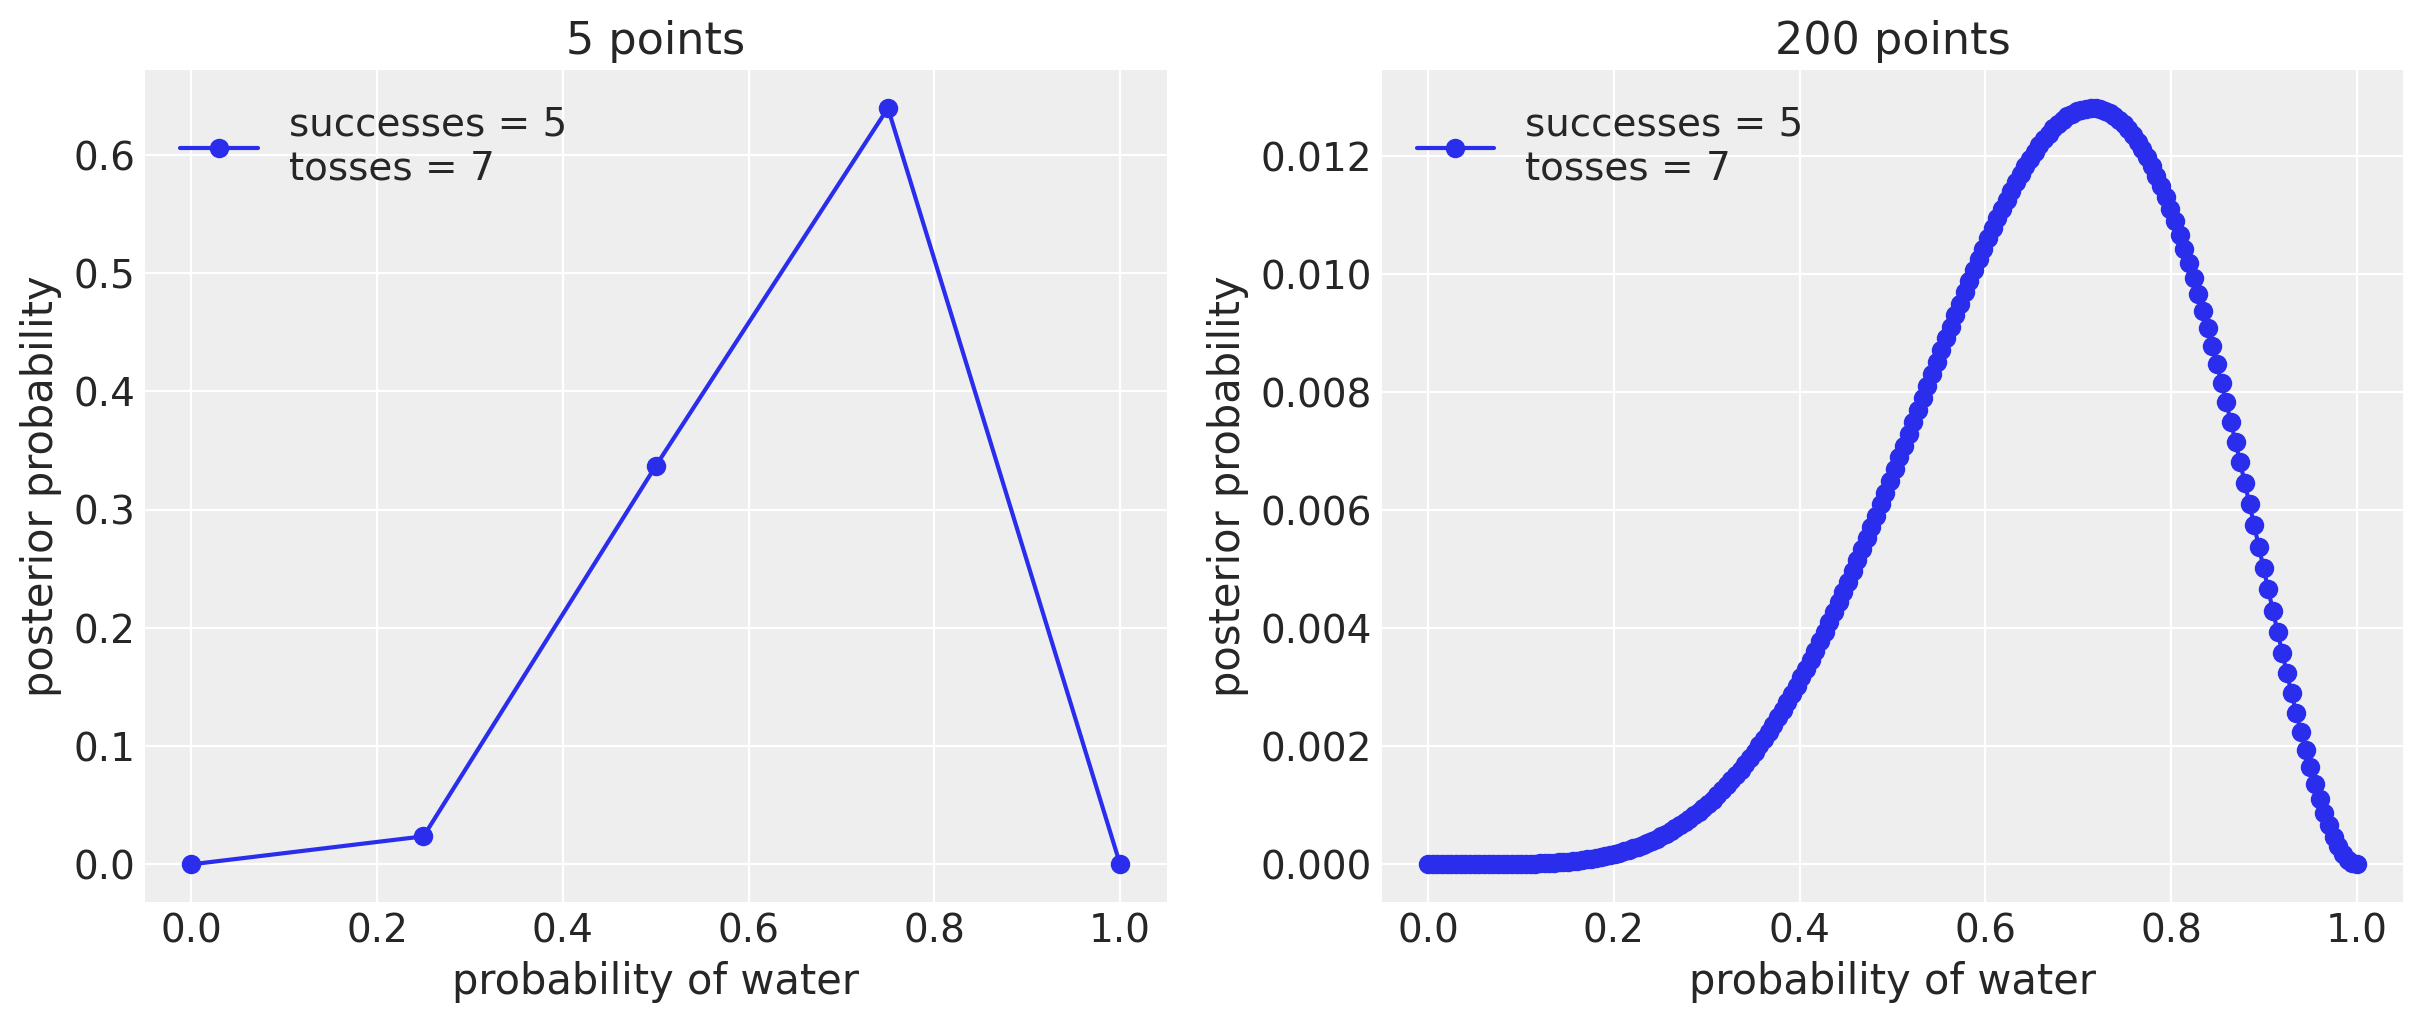

In [31]:
w, n = 5, 7

_, ax = plt.subplots(1, 2, figsize=(12, 5))

points = (5, 200)
for idx, ps in enumerate(points):
    p_grid, posterior = posterior_grid_approx(ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

#### 2M2

In [37]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
#     prior = np.repeat(1 / grid_points, grid_points)  # uniform
    prior = (p_grid >= 0.5).astype(int)  # truncated
#     prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

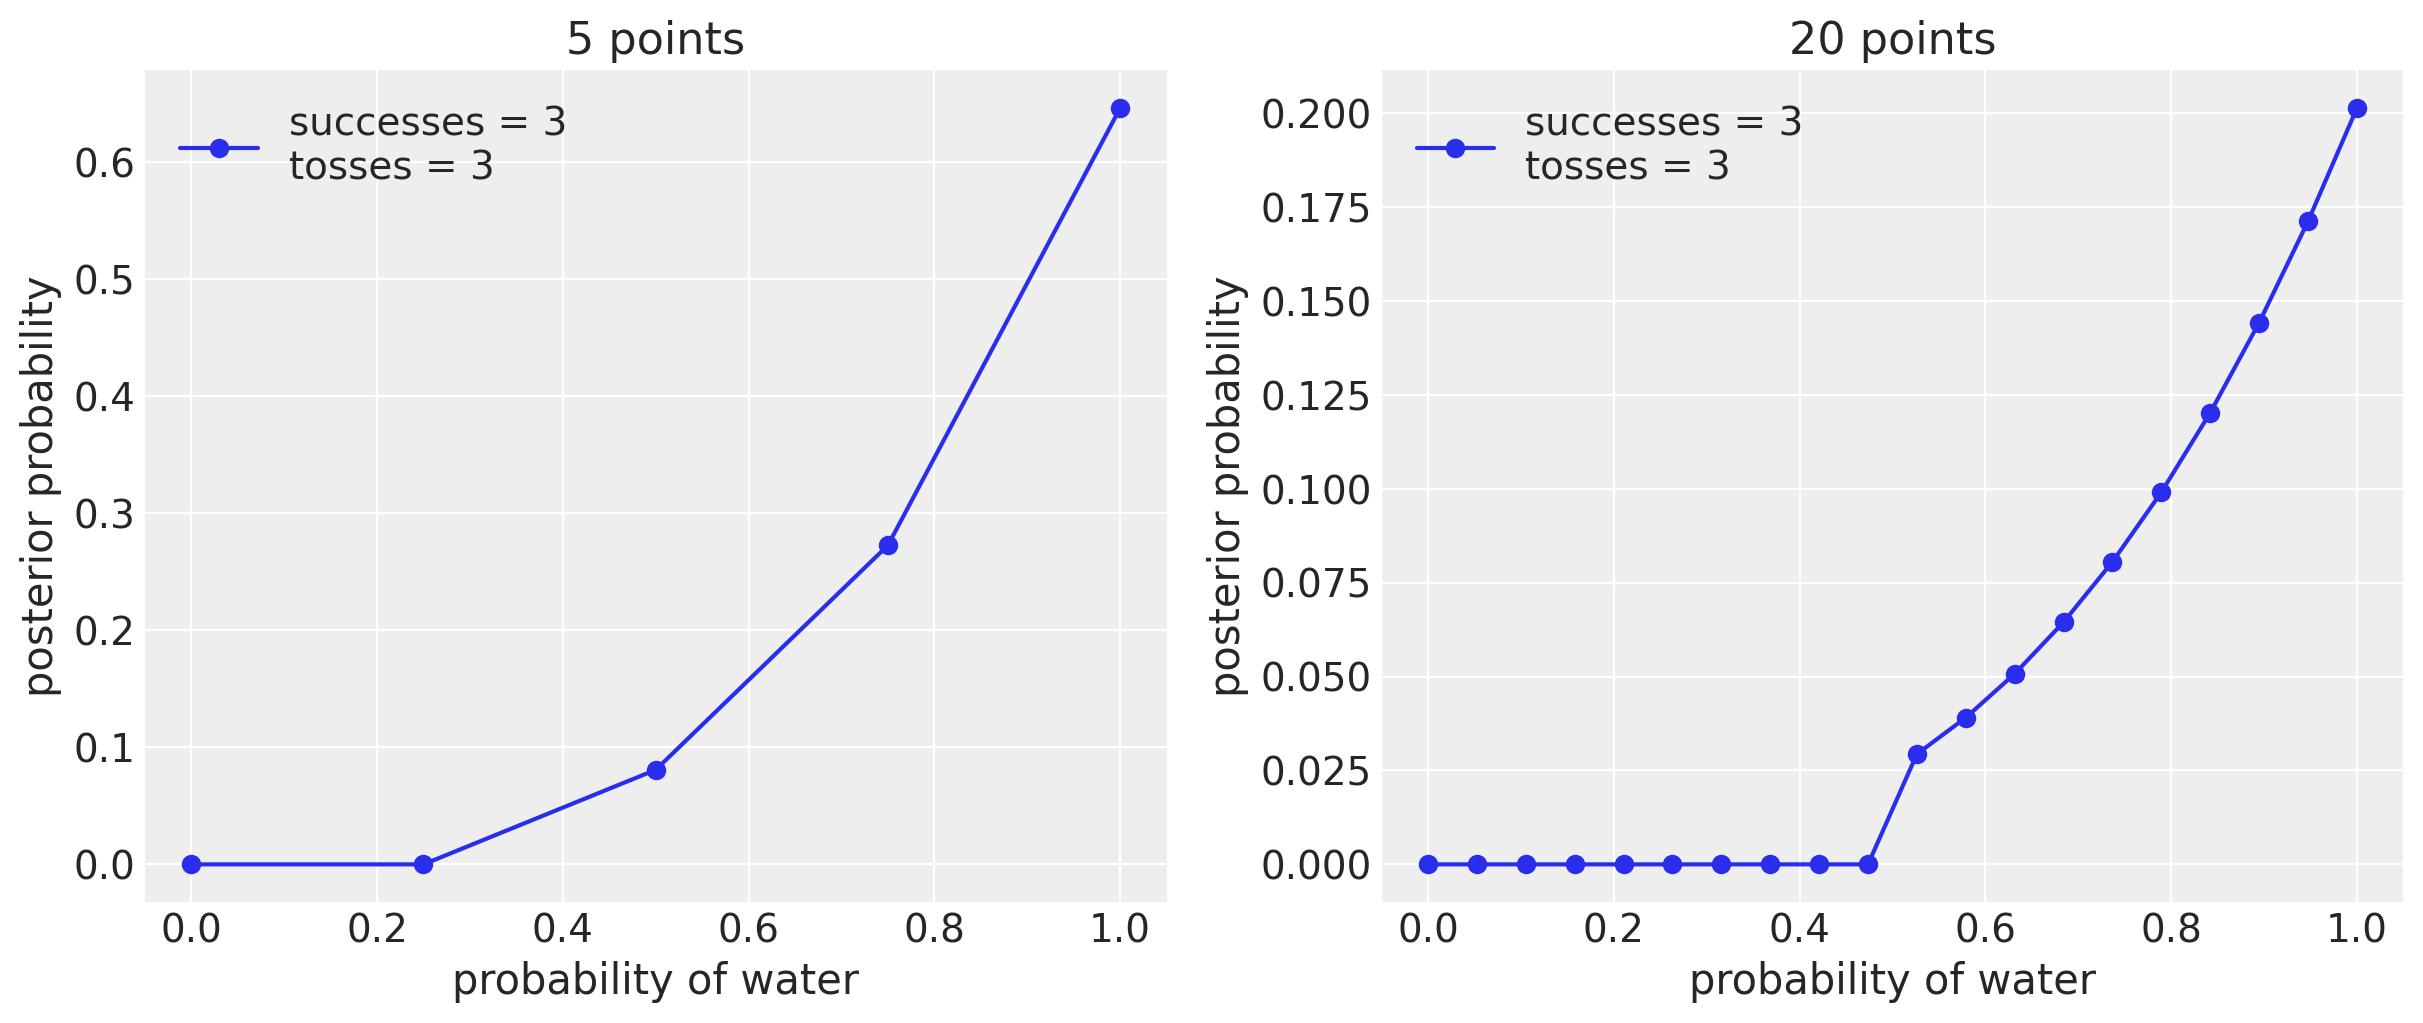

In [38]:
w, n = 3, 3

_, ax = plt.subplots(1, 2, figsize=(12, 5))

points = (5, 20)
for idx, ps in enumerate(points):
    p_grid, posterior = posterior_grid_approx(ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

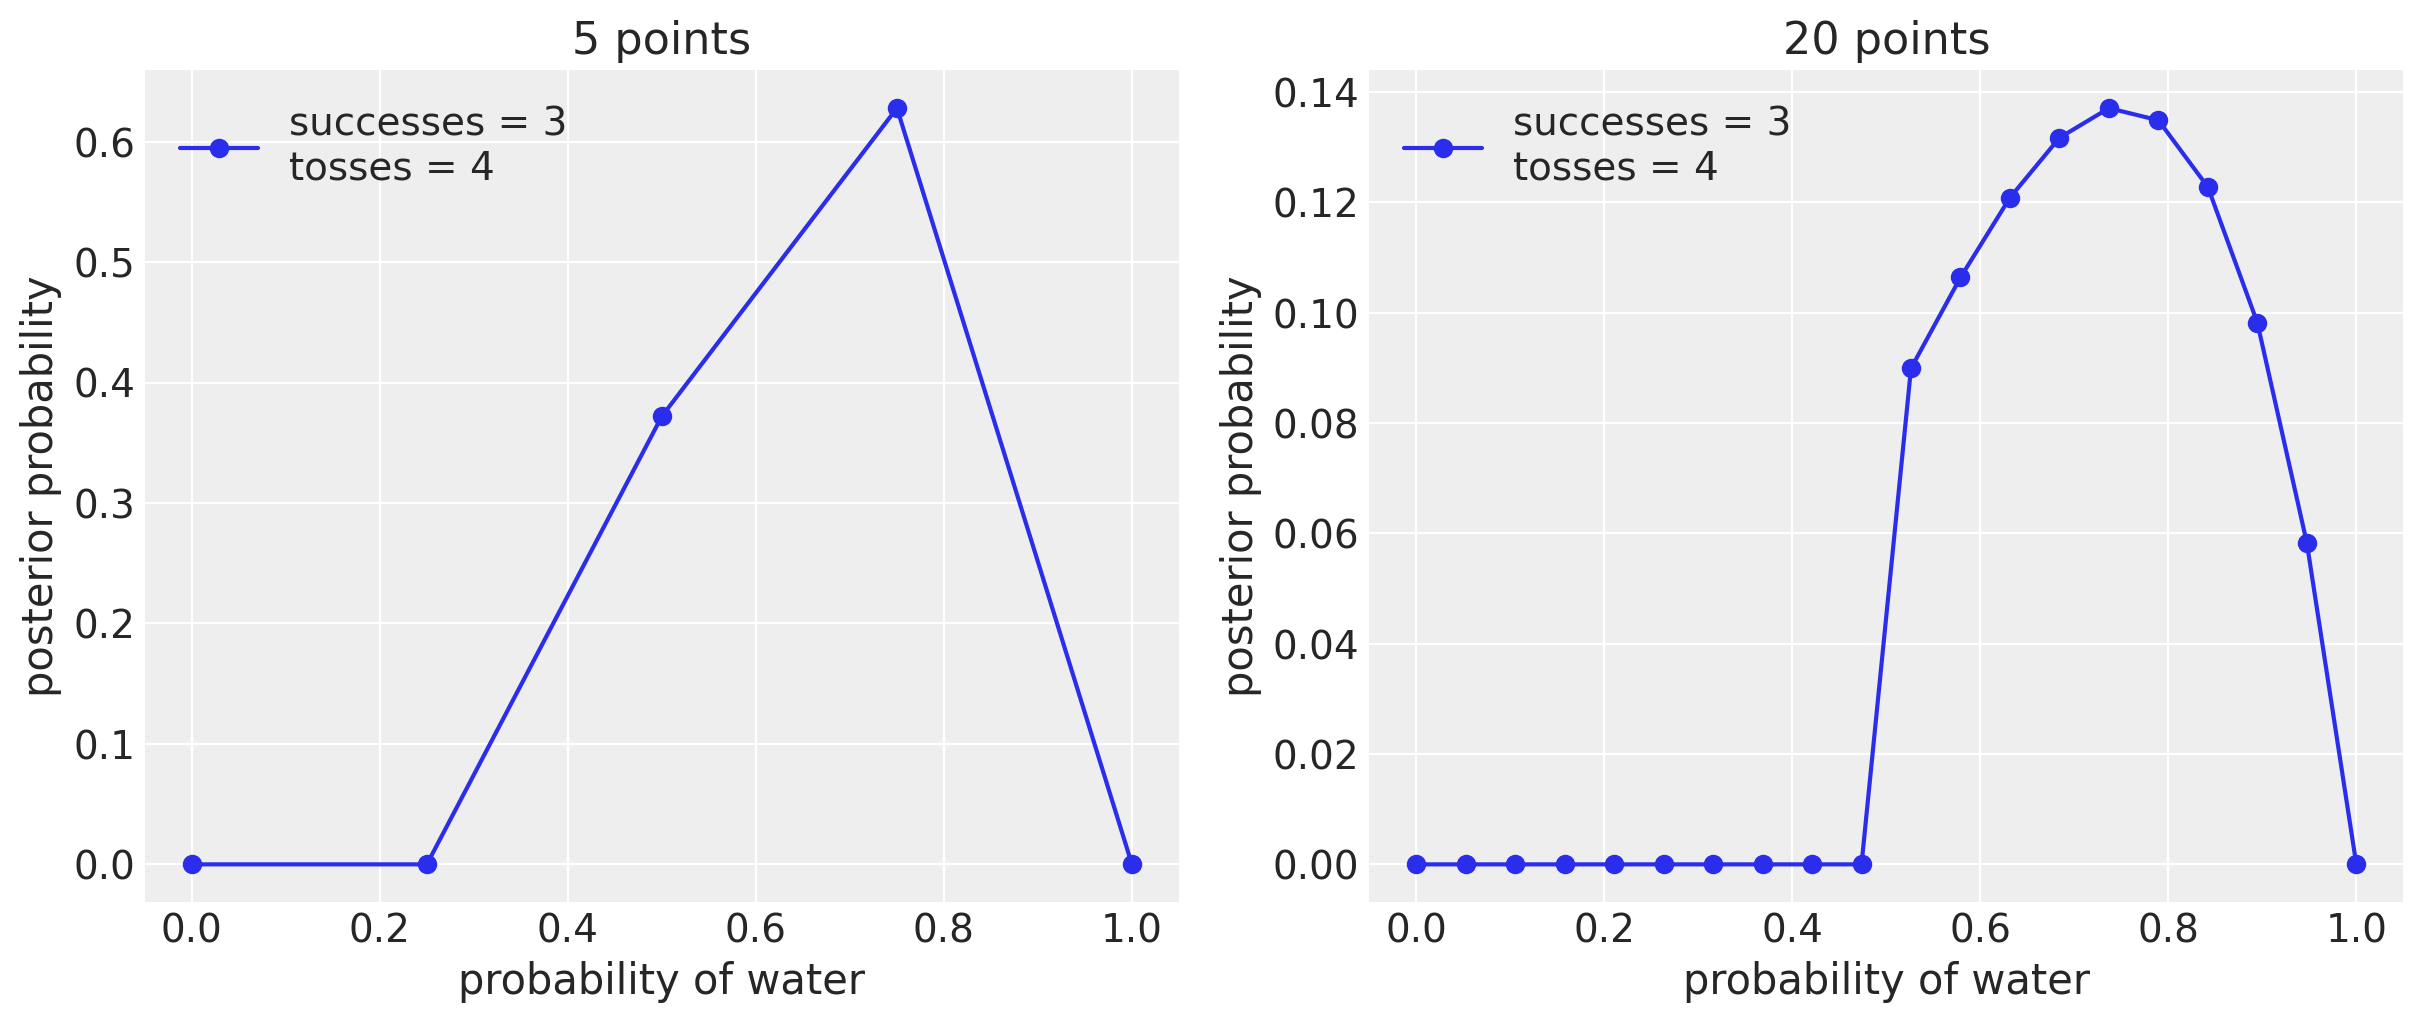

In [39]:
w, n = 3, 4

_, ax = plt.subplots(1, 2, figsize=(12, 5))

points = (5, 20)
for idx, ps in enumerate(points):
    p_grid, posterior = posterior_grid_approx(ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

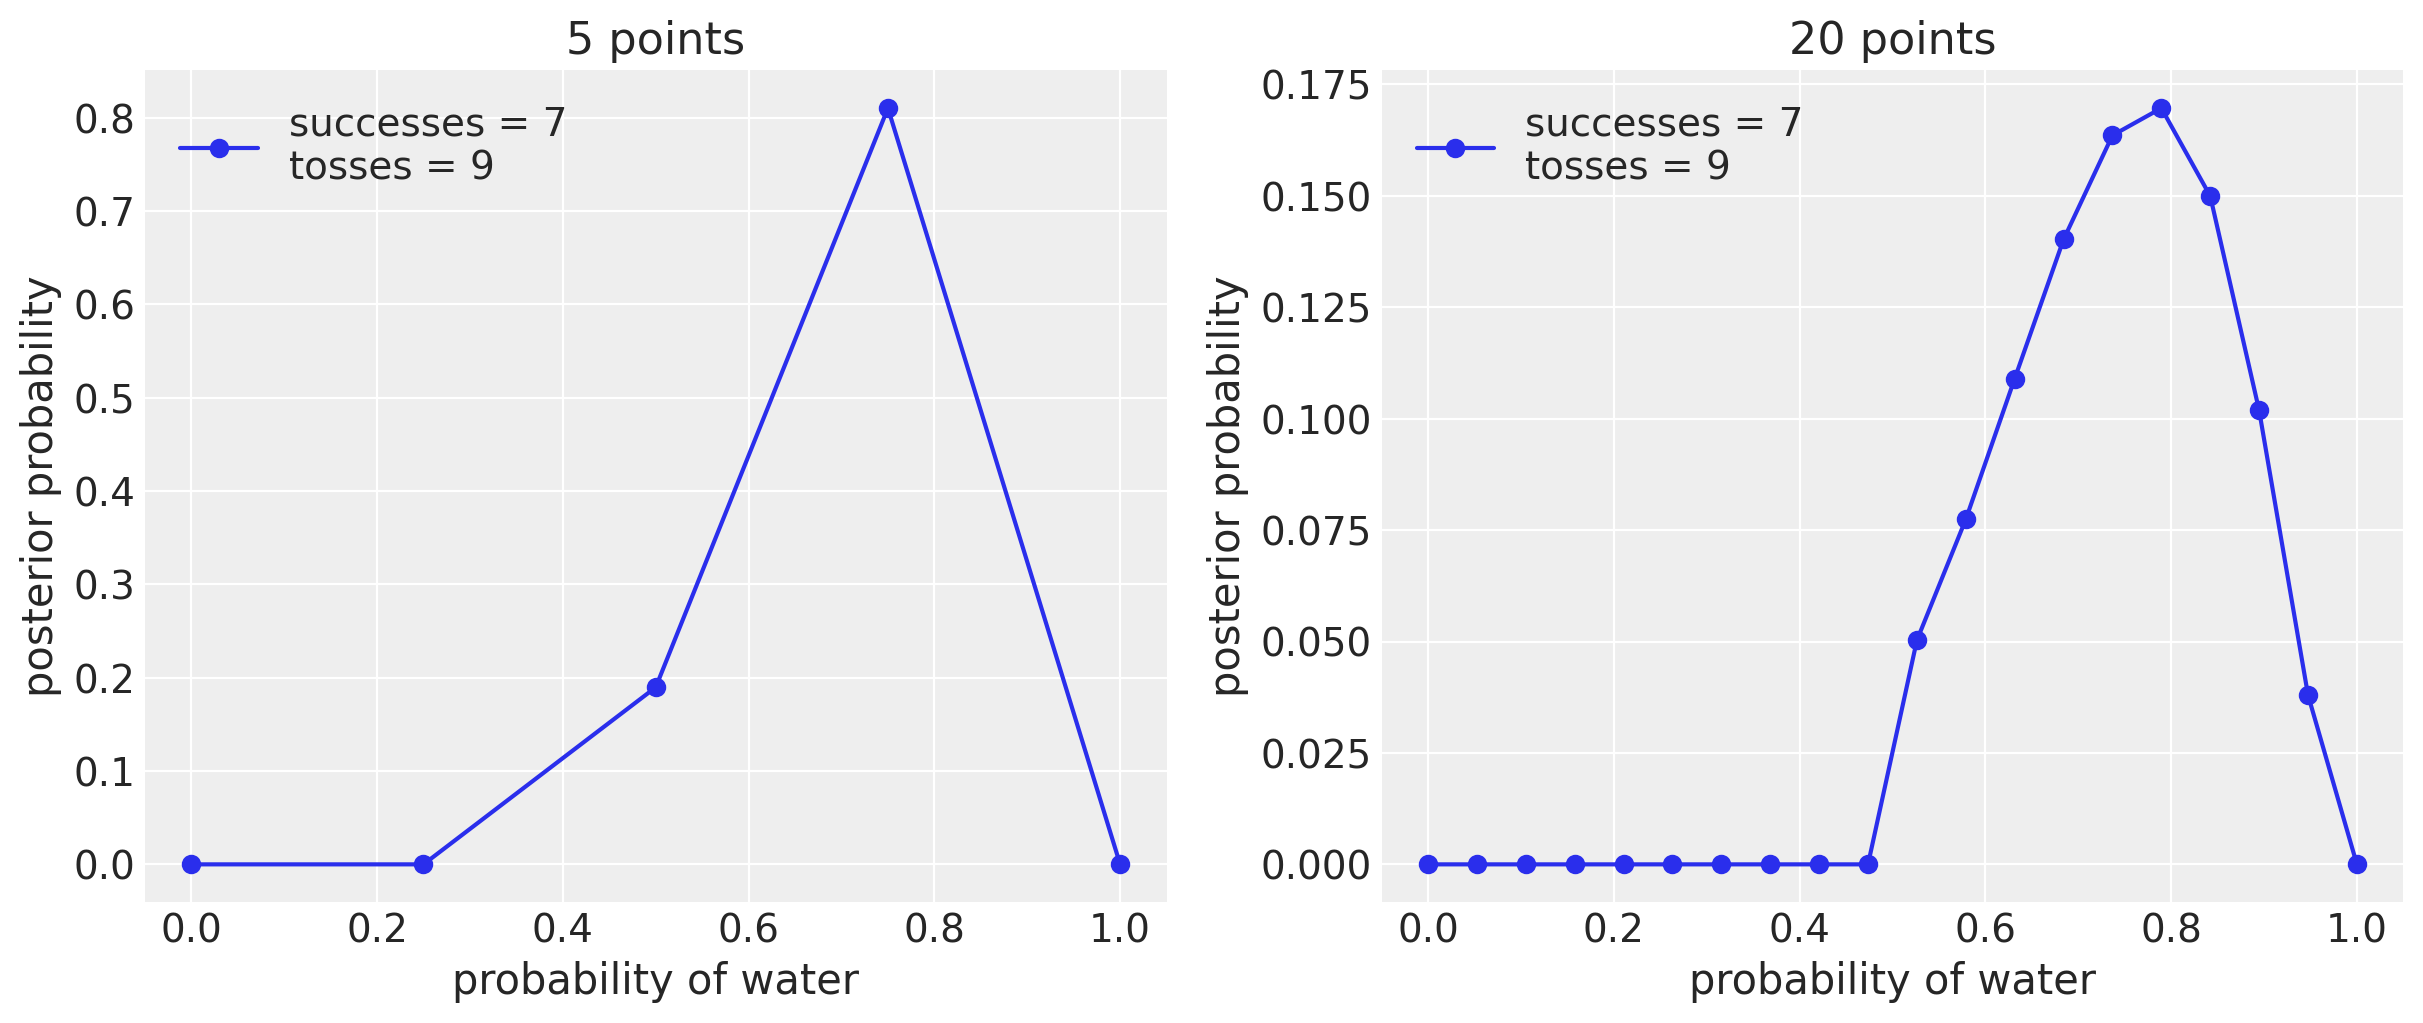

In [40]:
w, n = 7, 9

_, ax = plt.subplots(1, 2, figsize=(12, 5))

points = (5, 20)
for idx, ps in enumerate(points):
    p_grid, posterior = posterior_grid_approx(ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

#### 2M3
$$Posterior = \frac{Probablity \; of \; the \; data \; \times \; Prior}{Average \; probability \; of \; the \; data}$$

In [46]:
prior_earth = 0.5
prior_mars = 1 - prior_earth
probability_of_land_given_earth = 0.3
posterior_earth_given_land = probability_of_land_given_earth * prior_earth \
/ (probability_of_land_given_earth * prior_earth + 1 * prior_mars)
posterior_earth_given_land

0.23076923076923075

#### 2M4

|  Conjecture | Ways to produce B| Probability|
|---|---|---|
|  BB |  2 |  2/3 |
|  BW |  1 |  1/3 |
|  WW |  0 | 0    |

#### 2M5

|  Conjecture | Ways to produce B| Prior count| New count| Probability|
|---|---|---|---|---|
|  BB |  2 |  2 |  4 |  4/5 |
|  BW |  1 |  1 |  1 |  1/5 |
|  WW |  0 |  1 |  0 |   0  |

#### 2M6

|  Conjecture | Ways to produce B| Prior count| New count| Probability|
|---|---|---|---|---|
|  BB |  2 |  1 |  2 |  1/2 |
|  BW |  1 |  2 |  2 |  1/2 |
|  WW |  0 |  3 |  0 |   0  |

#### 2M7

|  Conjecture | Ways to produce B| Ways to produce W from another card| New count| Probability |
|---|---|---|---|---|
|  BB |  2 |  3 | 6 | 3/4 |
|  BW |  1 |  2 | 2 | 1/4 |
|  WW |  0 |  1 | 0 | 0 |

#### 2H1

In [55]:
prior_sA = 0.5
prior_sB = 0.5

probability_twins_sA = 0.1
probability_twins_sB = 0.2

posterior_sA = (prior_sA * probability_twins_sA) / (prior_sA * probability_twins_sA + prior_sB * probability_twins_sB)
posterior_sB = 1 - posterior_sA

In [56]:
probability_twins = posterior_sA * probability_twins_sA + posterior_sB * probability_twins_sB

In [57]:
probability_twins

0.16666666666666669

#### 2H2

In [58]:
posterior_sA

0.3333333333333333

#### 2H3

In [59]:
prior_sA_first_twin = posterior_sA
prior_sB_first_twin = posterior_sB

posterior_sA_first_twin = (prior_sA_first_twin * (1 - probability_twins_sA)) \
/ (prior_sA_first_twin  * (1 - probability_twins_sA) + prior_sB_first_twin  * (1 - probability_twins_sB))

posterior_sA_first_twin

0.35999999999999993

#### 2H4

In [65]:
probability_correct_sA = 0.8
probability_correct_sB = 0.65

prior_sA = 0.5
prior_sB = 0.5

posterior_sA = (prior_sA * probability_correct_sA) / (prior_sA * probability_correct_sA + prior_sB * probability_correct_sB)
posterior_sB = 1 - posterior_sA

posterior_sA

0.5517241379310345

In [66]:
prior_sA = posterior_sA_first_twin
prior_sB = 1 - posterior_sA_first_twin

In [67]:
posterior_sA = (prior_sA * probability_correct_sA) / (prior_sA * probability_correct_sA + prior_sB * probability_correct_sB)
posterior_sB = 1 - posterior_sA

posterior_sA

0.409090909090909